## Example Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
!pip install -r requirements.txt

In [1]:
import pandas as pd
import cfe.regression as rgsn

### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [2]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

#### Prices, FCT, RDI



In [3]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for instructors@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for instructors@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for instructors@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [4]:
r = rgsn.read_pickle('uganda_2019-20.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [5]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2019-20',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

In [6]:
pbar

j
Beans              3952.083333
Beef              10500.000000
Biscuits           2750.000000
Bread              4625.000000
Cabbages           2349.147731
Cassava            1162.622549
Chapati            1750.000000
Cooking Oil        2060.984848
Dodo                958.333333
Eggs               1750.000000
Fish (dried)       2990.303510
Fish (fresh)       4224.050725
Goat              11000.000000
Ground Nuts        5607.965686
Maize              2073.775054
Mangos              607.477121
Matoke             1556.997715
Milk (fresh)       2933.333333
Millet             3958.333333
Onions             1239.583333
Oranges             713.848039
Other Fruits       2741.789875
Other Veg.         1108.987403
Peas               5208.333333
Pork              10250.000000
Rice               3575.000000
Salt               1400.000000
Sim Sim           12454.166667
Soda               3333.333333
Sorghum            1625.000000
Sweet Bananas      1378.308824
Sweet Potatoes     1019.934641
Tea   

#### Budgets



Get food budget for all households, then find median budget:



In [11]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [10]:
xref

109535.58483482643

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [12]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.908344,0.873736,0.278641,0.679694,0.542311,7.076232,1.225904,0.768595,2.102513,1.300093,...,1.904098,0.210626,0.169969,0.828589,1.032246,1.855447,9.106649,0.020781,2.065636,0.547677
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.630212,0.704890,0.332241,0.547917,0.386812,4.651378,1.117598,0.688879,1.406102,1.218035,...,1.200659,0.159736,0.182561,0.863060,0.734592,1.631692,5.637060,0.015357,1.934006,1.241320
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.613338,0.545572,0.129055,0.371819,0.290441,5.161206,0.725595,0.516824,1.212362,0.887650,...,0.853833,0.156937,0.098278,0.419683,0.466584,0.810668,5.261903,0.011435,1.357342,0.826227
1013000201,2019-20,Central,0.962721,1.172347,1.375567,1.003591,0.523225,3.037451,1.864472,0.697341,2.265463,1.793179,...,1.355894,0.143342,0.210153,1.689991,0.925546,2.539598,4.600645,0.029232,2.506099,0.878415
1013000202,2019-20,Central,0.783036,0.588576,0.214716,0.411769,0.272860,3.188167,0.608036,0.379958,1.262848,1.067309,...,0.643904,0.167656,0.066803,0.347818,0.351393,0.987588,3.197720,0.013198,1.131102,0.537512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1.474756,1.084495,0.410866,0.612537,0.532731,9.631213,1.567699,0.878762,2.330314,1.518435,...,2.209271,0.280835,0.231877,1.055073,1.601185,3.907814,13.453670,0.018543,2.189298,1.929582
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,0.642402,0.678325,0.525649,0.425417,0.313321,2.507347,0.838033,0.409256,1.410044,1.156874,...,0.680075,0.119045,0.100621,0.794967,0.405909,1.185200,3.030198,0.017108,1.345186,0.515554
d10a687889de469687377204195f3db0,2019-20,Western,1.293502,0.857205,0.451531,0.512783,0.420744,4.915754,0.880891,0.635583,1.252812,1.400779,...,0.730574,0.249491,0.527720,0.737261,1.414265,1.657020,3.251340,0.025992,2.019768,0.922988


Finally, define a function to change a single price in the vector $p$:



In [13]:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

#### Demand functions



In [15]:
r.demands(xref,pbar)

j
Beans             1.113994
Beef              0.757108
Biscuits          1.449861
Bread             1.044612
Cabbages          1.384073
Cassava           1.260060
Chapati           2.039503
Cooking Oil       1.494391
Dodo              1.904544
Eggs              1.474588
Fish (dried)      1.339340
Fish (fresh)      1.284735
Goat              0.701225
Ground Nuts       1.001796
Maize             1.506909
Mangos            2.800034
Matoke            1.760485
Milk (fresh)      1.583963
Millet            1.104047
Onions            1.654919
Oranges           4.052542
Other Fruits      1.569627
Other Veg.        2.572395
Peas              1.007345
Pork              0.782491
Rice              1.250804
Salt              1.220986
Sim Sim           0.632187
Soda              1.287945
Sorghum           2.185091
Sweet Bananas     2.192677
Sweet Potatoes    1.728655
Tea               0.751159
Tomatoes          2.770237
Waragi            0.977643
Name: quantities, dtype: float64

<IPython.core.display.Javascript object>


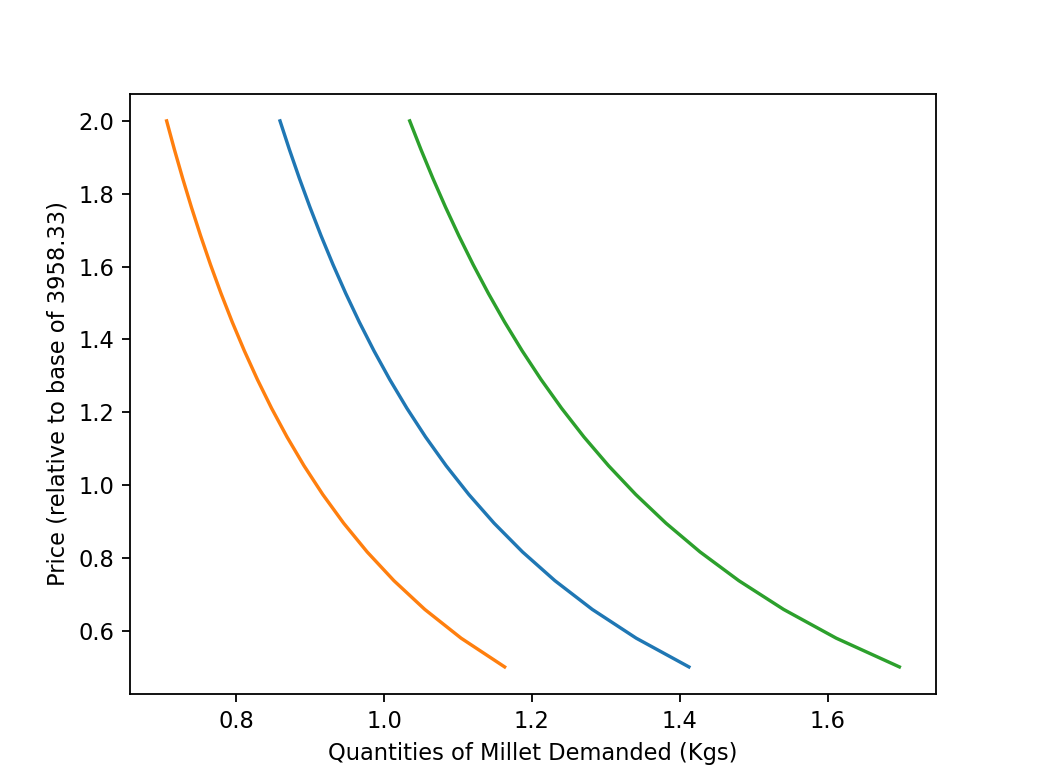

Text(0.5, 0, 'Quantities of Millet Demanded (Kgs)')

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Millet'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded (Kgs)")

#### Engel Curves



<IPython.core.display.Javascript object>


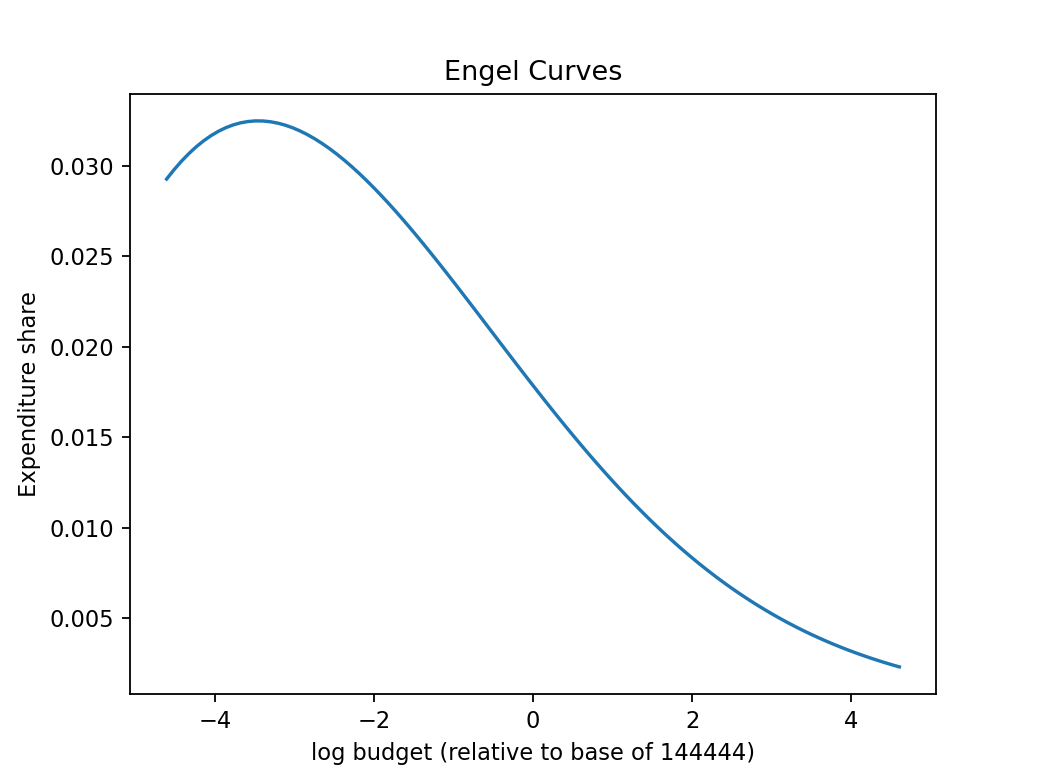

Text(0.5, 1.0, 'Engel Curves')

In [18]:
fig,ax = plt.subplots()

scale = np.geomspace(0.01,100,100)
ax.plot(np.log(scale),[(r.expenditures(s*xref,pbar)/(s*xref))['Eggs'] for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')